In [317]:
import warnings
import importlib
from itertools import chain

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as m
import scipy.stats
import sklearn
import sklearn_crfsuite
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve, RandomizedSearchCV
from sklearn_crfsuite import metrics, scorers

import features
import util
import analysis

importlib.reload(analysis)

<module 'analysis' from '/home/shivanshs9/Projects/Junk/NLP/HindiChunking/analysis.py'>

In [241]:
plt.style.use('ggplot')
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [242]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


# Word Level Error Analysis

In [243]:
WORDS = ('नहीं', 'खाना', 'और', 'बिना')

def count_and_print_errors(n, f=None, seq=None):
    cnt = 0
    if seq is not None:
        cor_seq = {}
        wrg_seq = {}
    for i, s_true_y in enumerate(test_y):
        if cnt == n:
            break
        s_pred_y = y_pred[i]
        s_x = zipped_test_x[i]
        for j, true_y in enumerate(s_true_y):
            if cnt == n:
                break
            x = s_x[j]
            pred_y = s_pred_y[j]
            if true_y != pred_y:
                cnt += 1
                if f:
                    print(" ".join([w['word'] for w in s_x]), file=f)
                    print([w['word_postag'] for w in s_x], file=f)
                    print([w for w in s_pred_y], file=f)
                    print([w for w in s_true_y], file=f)
                    print('\n', file=f)
                if seq is not None and x['word'] in WORDS:
                    key = f'{x["word"]}'
                    wrg_seq[key] = wrg_seq.setdefault(key, 0) + 1
            elif seq is not None and x['word'] in WORDS:
                key = f'{x["word"]}'
                cor_seq[key] = cor_seq.setdefault(key, 0) + 1
    if seq is not None:
        keys = WORDS#set(cor_seq.keys()) | set(wrg_seq.keys())
        for key in keys:
            seq[key] = cor_seq.get(key, 0) / (cor_seq.get(key, 0) + wrg_seq.get(key, 0))
    return cnt


In [244]:
# For finding the optimized hyperparameters

def find_best_hyperparameters(estimator, data_x, data_y, labels):
    # use the same metric for evaluation
    f1_scorer = make_scorer(metrics.flat_f1_score, average='weighted', labels=labels)

    # Searching in params_space for best results
    params_space = {
        'c1': scipy.stats.expon(scale=0.5),
        'c2': scipy.stats.expon(scale=0.05),
    }
    rs = RandomizedSearchCV(estimator, params_space, cv=3, n_jobs=4, n_iter=50, scoring=f1_scorer)
    rs.fit(data_x, data_y)
    print('best params:', rs.best_params_)
    print('best CV score:', rs.best_score_)
    print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))
    return rs.best_estimator_


# Declaring Feature Sets

In [245]:
# This is for deciding on what features we need to do our analysis

MODE_LIST = [0, 1, 2, 3, 8, 11, 16, 24]
## Mode Bits
# 0 - Gender
# 1 - Number
# 2 - Person
# 3 - Case
# 4 - Root Word & Whether same
# 5 - Give bias to NEGP

In [246]:
print('Loading data...')

data = util.convertFromSSF('data_clean.txt')
print(f'# of sentences = {len(data)}')
data_x = [features.sentToFeatures(s, MODE_LIST) for s in data]
data_y = [features.sentToLabels(s) for s in data]

# Setting the training and testing data
print('Splitting data at 70%:30%...')
train_X, test_X, train_Y, test_y = train_test_split(data_x, data_y, test_size=0.3, random_state=123)

Loading data...
# of sentences = 21086
Splitting data at 70%:30%...


# Finding classification labels

In [256]:
labels = set(chain(*data_y))
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)

chunk_labels = sorted(set(map(lambda lbl: lbl[2:], sorted_labels)))

# Setting the model

In [257]:
# c1 and c2 parameter values are obtained from randomized search in hyperparameters space
# Best estimated F1 score = 0.9745285762169615
crf = sklearn_crfsuite.CRF(algorithm="lbfgs", c1=0.2096570893088954, c2=0.038587807344039826, max_iterations=50, all_possible_transitions=True)

In [258]:
# find_best_hyperparameters(crf, [s[1] for s in train_X], train_Y, sorted_labels)

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=2, test_size=0.2, random_state=0)

# Fit, Predict & Report for each feature set

In [300]:
## Working for each mode differently
report = {}
modeseq = {}

modechunk = {}
for mode in MODE_LIST:
    zipped_train_x = [s[mode] for s in train_X]
    zipped_test_x = [s[mode] for s in test_X]
    # plot_learning_curve(crf, f'Learning curve for MODE {mode}', [s[mode] for s in train_X], train_Y, ylim=(0.7, 1.01), cv=cv, n_jobs=6)
    # plt.show()

    print('Fitting the model for MODE (' + str(mode) + ') ...')
    crf.fit(zipped_train_x, train_Y)

    print('Predicting labels...')
    y_pred = crf.predict(zipped_test_x)

    print('F1 score: ', metrics.flat_f1_score(test_y, y_pred, average='weighted'))

    report[mode] = metrics.flat_classification_report(
        test_y, y_pred, labels=sorted_labels, digits=3, output_dict=True
    )
    
    ### Word/Chunk Level Analysis ==================================================================================================

    seqCorrect = analysis.getChnkSeqCorr(test_y)
    seqPredicted = analysis.getChnkSeqPred(test_y, y_pred)
    tagSeqList = analysis.analyzeChnkTagSeq(seqCorrect, seqPredicted, chunk_labels)    
    bndMeasures = analysis.analyzeChnkBoundaries(seqCorrect, seqPredicted, chunk_labels)

    modechunk[mode] = (seqCorrect, seqPredicted, tagSeqList, bndMeasures)
    
    seq = {}
    itms = seq.items()
    print(f'# of Errors = {count_and_print_errors(-1, seq=seq)}')
    modeseq[mode] = seq
    print()

Fitting the model for MODE (0) ...
Predicting labels...
F1 score:  0.9743432092164278
# of Errors = 3353

Fitting the model for MODE (1) ...
Predicting labels...
F1 score:  0.9742207922785058
# of Errors = 3370

Fitting the model for MODE (2) ...
Predicting labels...
F1 score:  0.9747063690773266
# of Errors = 3305

Fitting the model for MODE (3) ...
Predicting labels...
F1 score:  0.9744858570526507
# of Errors = 3333

Fitting the model for MODE (8) ...
Predicting labels...
F1 score:  0.9753641183595508
# of Errors = 3218

Fitting the model for MODE (11) ...
Predicting labels...
F1 score:  0.9754141902642991
# of Errors = 3216

Fitting the model for MODE (16) ...
Predicting labels...
F1 score:  0.9743401011181902
# of Errors = 3354

Fitting the model for MODE (24) ...
Predicting labels...
F1 score:  0.9752206188493475
# of Errors = 3242



In [207]:
res = {}
for mode, dct in report.items():
    for lbl, dct2 in dct.items():
        if lbl[0] not in ('B', 'I') or 'NULL' in lbl:
            continue
        for key, val in dct2.items():
            res.setdefault(key, dict())
            res[key].setdefault(mode, dict())
            res[key][mode][lbl] = val

In [187]:
def subcategorybar(X, vals, lbls, width=0.8):
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge", label=lbls[i])
    plt.xticks(_X, X)

In [401]:
def plot_score(data, ylabel='Metric value', title=None):
    plt.figure(figsize=(20, 12))
    if title:
        plt.title(title)
    X=[list(lbl.keys()) for lbl in data.values()][0]
    Y=[list(map(lambda val: 1*val, lbl.values())) for lbl in data.values()]
    subcategorybar(X, Y, lbls=[f'Mode {v}' for v in data.keys()], width=0.8)
    plt.ylabel(ylabel)
    plt.xlabel('Classes')
#     plt.ylim(bottom=20)
    plt.legend()
    plt.show()

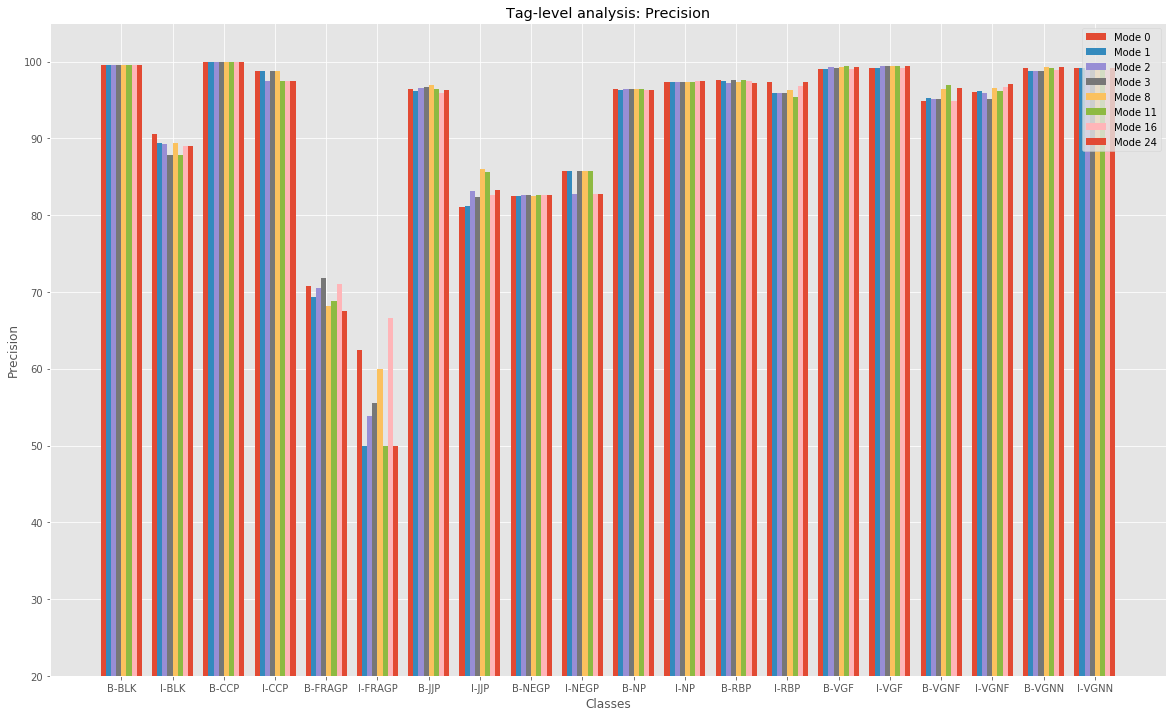

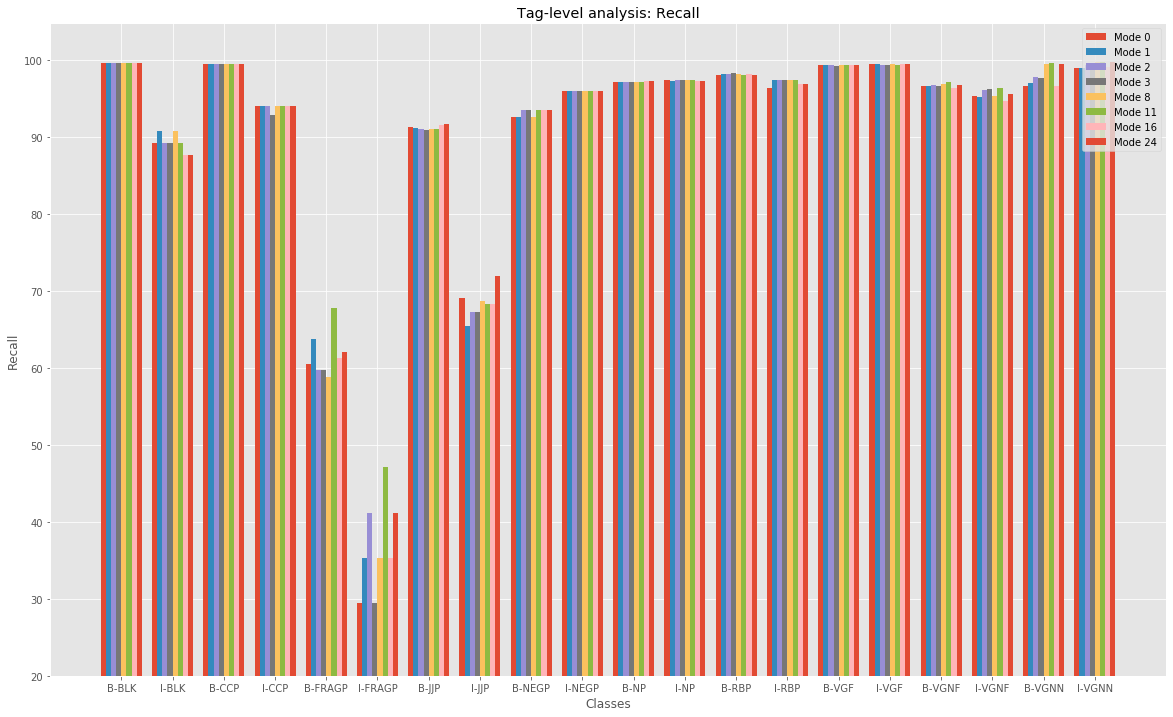

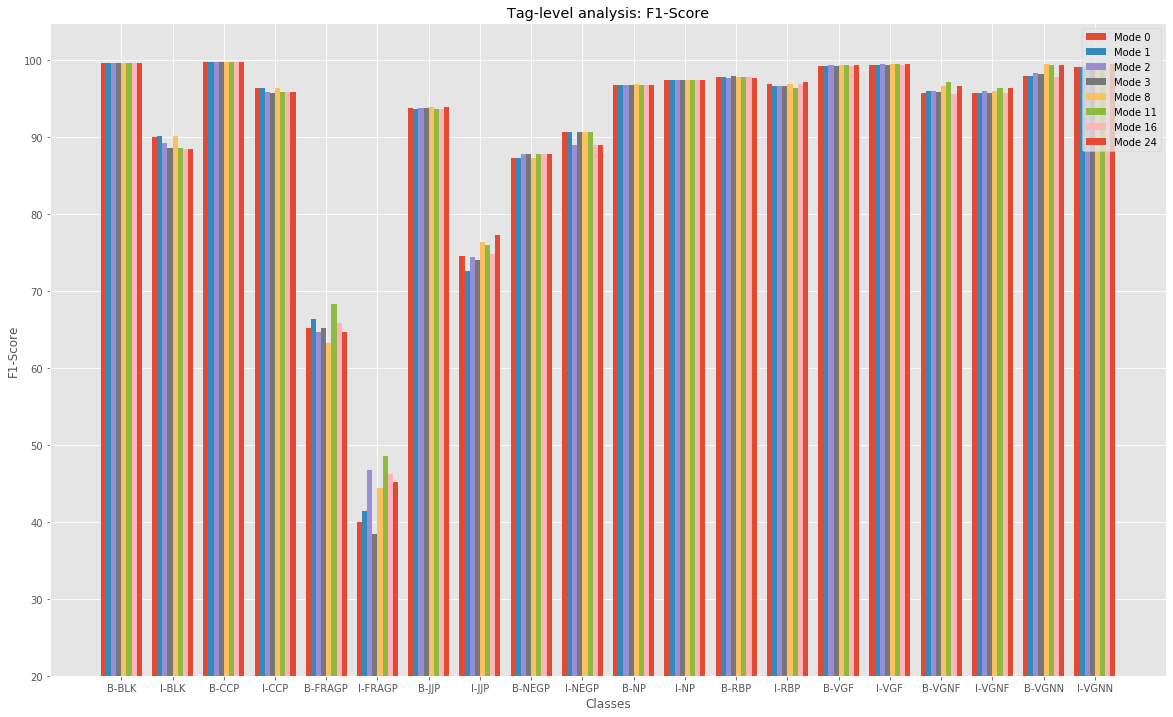

In [392]:
plot_score(res['precision'], ylabel="Precision", title='Tag-level analysis: Precision')
plot_score(res['recall'], ylabel="Recall", title='Tag-level analysis: Recall')
plot_score(res['f1-score'], ylabel="F1-Score", title='Tag-level analysis: F1-Score')

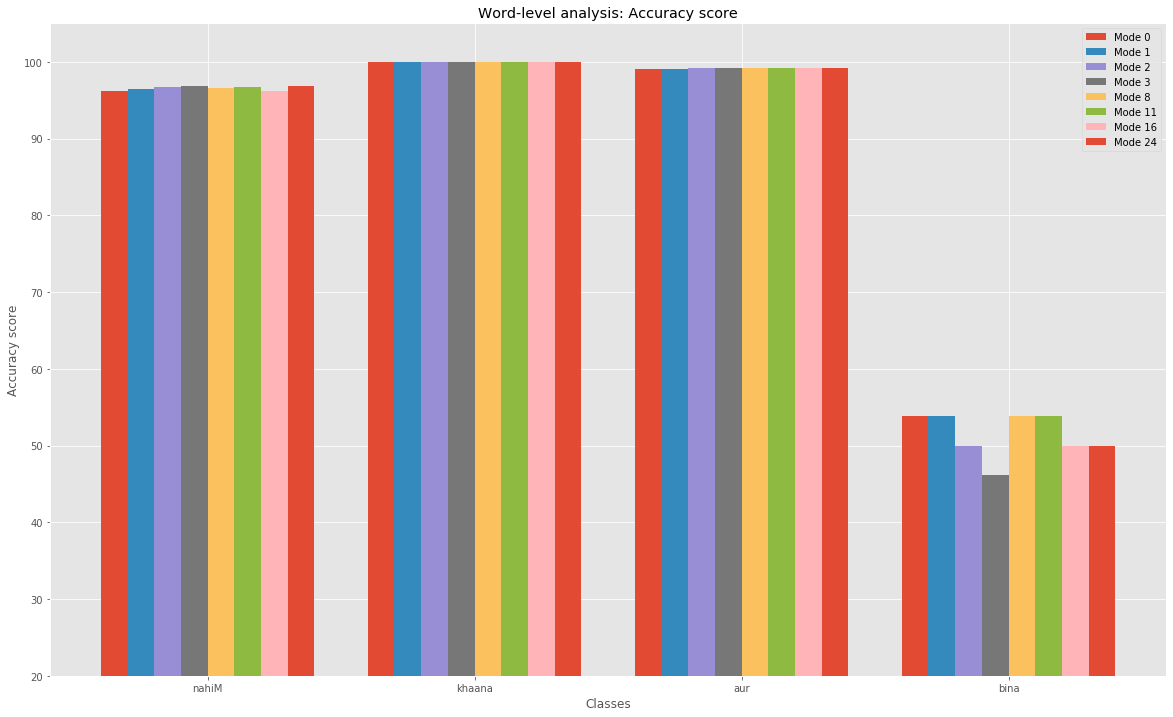

In [236]:
TRANS_MAP = {
    'नहीं': 'nahiM',
    'खाना': 'khaana',
    'बिना': 'bina',
    'और': 'aur'
}

wdata = dict([(key, dict([(TRANS_MAP[k], v) for k,v in dct.items()])) for key, dct in modeseq.items()])

plot_score(wdata, ylabel='Accuracy score', title='Word-level analysis: Accuracy score')

In [260]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [325]:
HIGH = 6

def process_sequence(pred_mat, corr_mat):
    # Predicted(P) / Correct (C)
    # if C==0 and P!=0, inf value
    data = list()
    row_lbls = list()
    col_lbls = list()
    for key1, dct in pred_mat.items():
        tmp = list()
        col_lbls.append(key1)
        for key2, den in dct.items():
            num = corr_mat[key1][key2]
            if num == 0:
                if den == 0:
                    val = 1
                else:
                    val = HIGH
            else:
                val = den / num
            tmp.append(val)
            row_lbls.append(key2)
        data.append(tmp)
    return (data, row_lbls, col_lbls)

# Sequence-level HeatMap

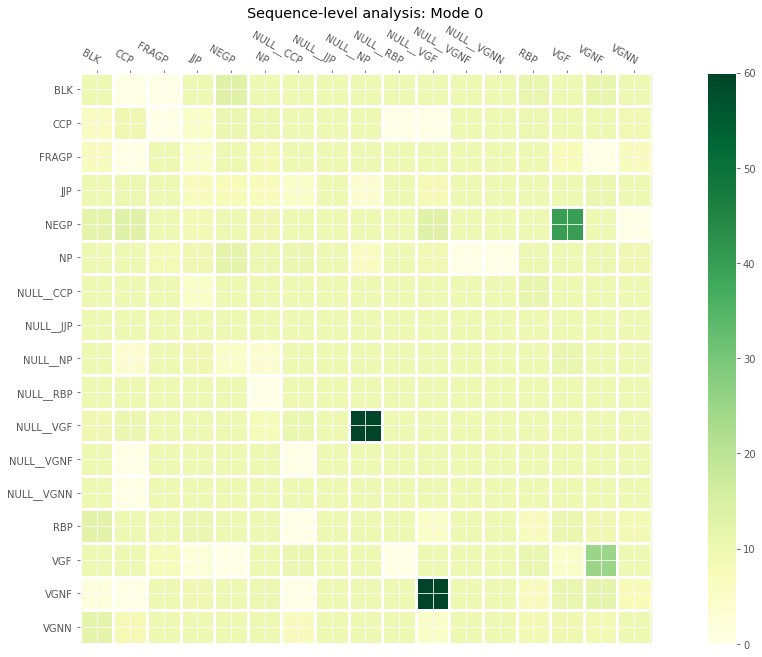

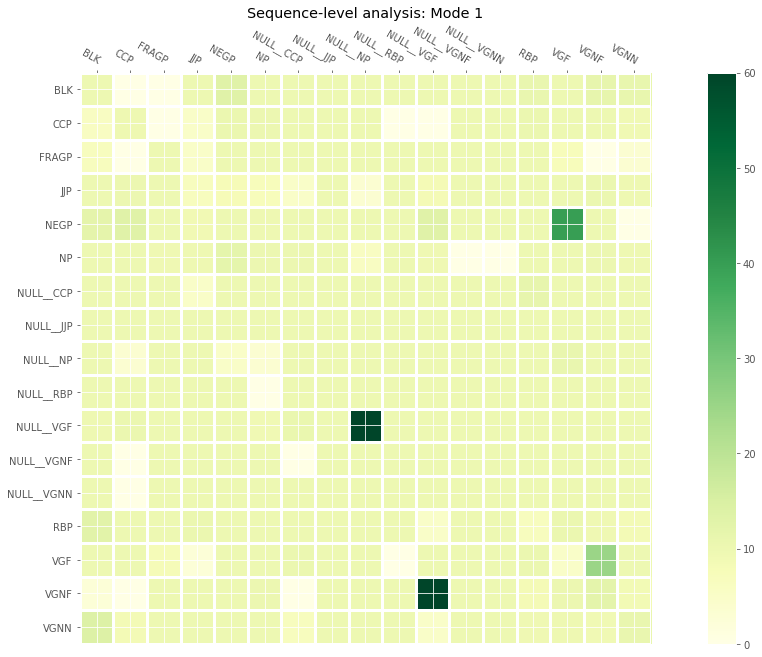

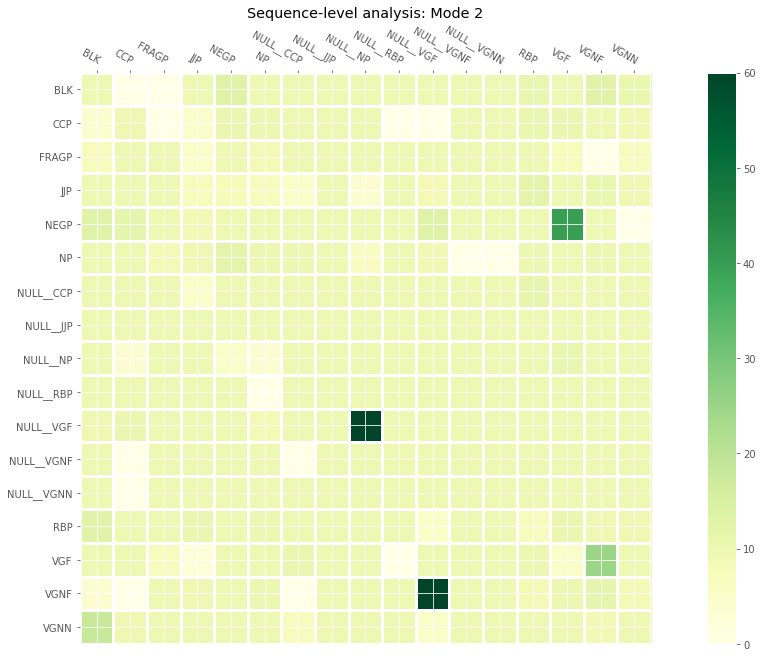

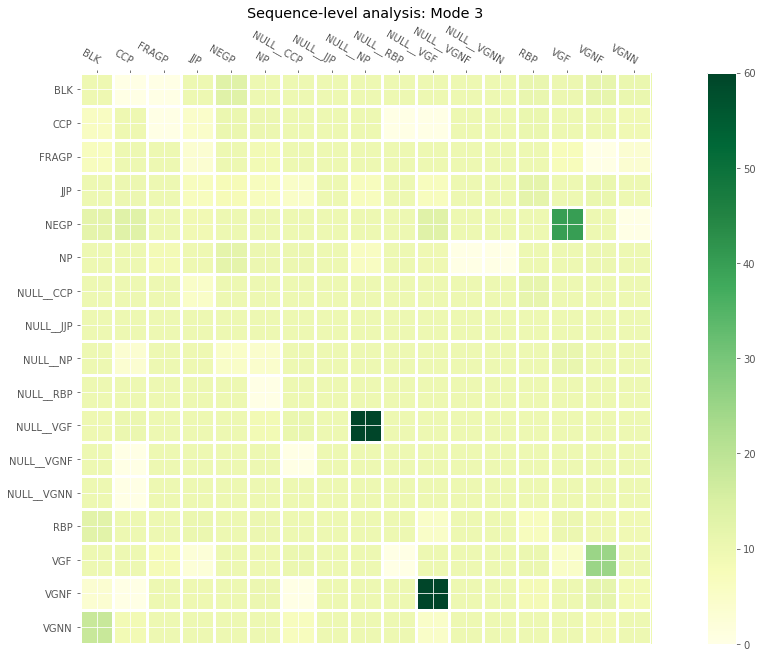

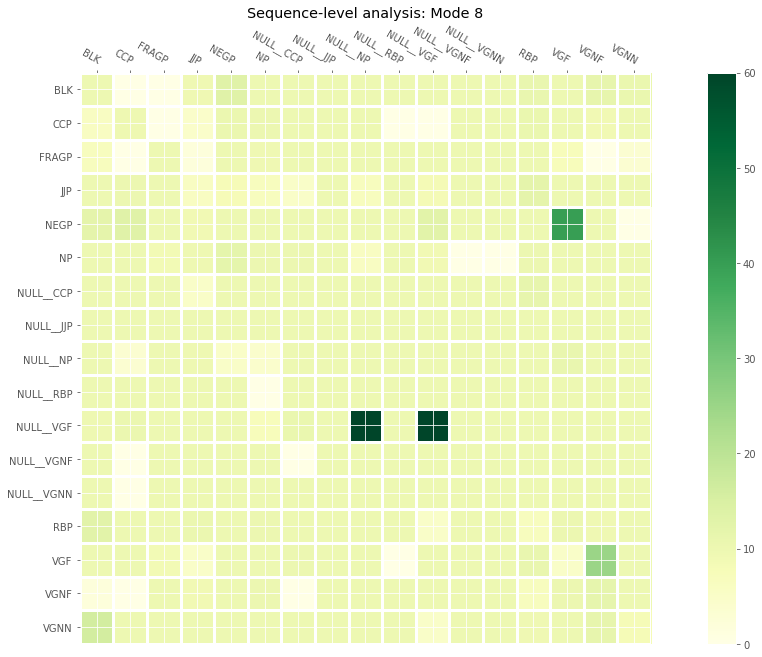

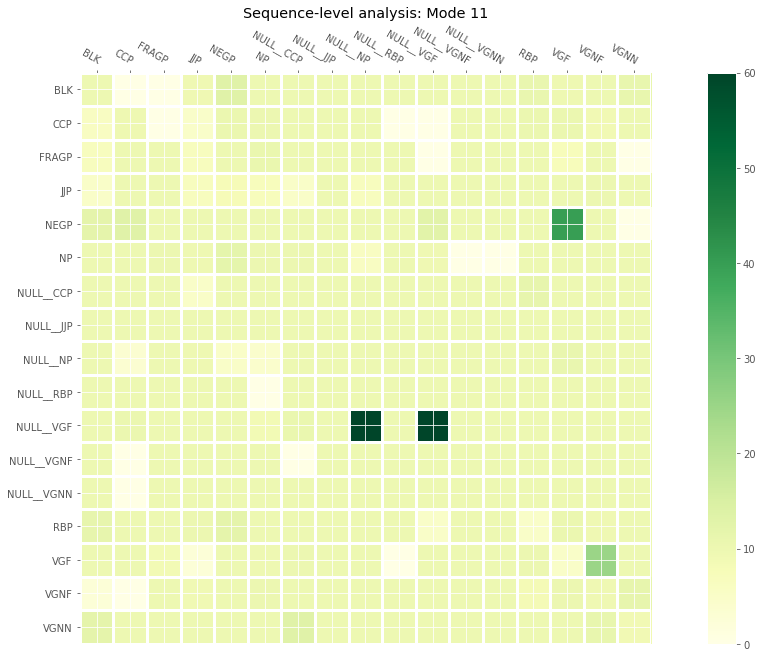

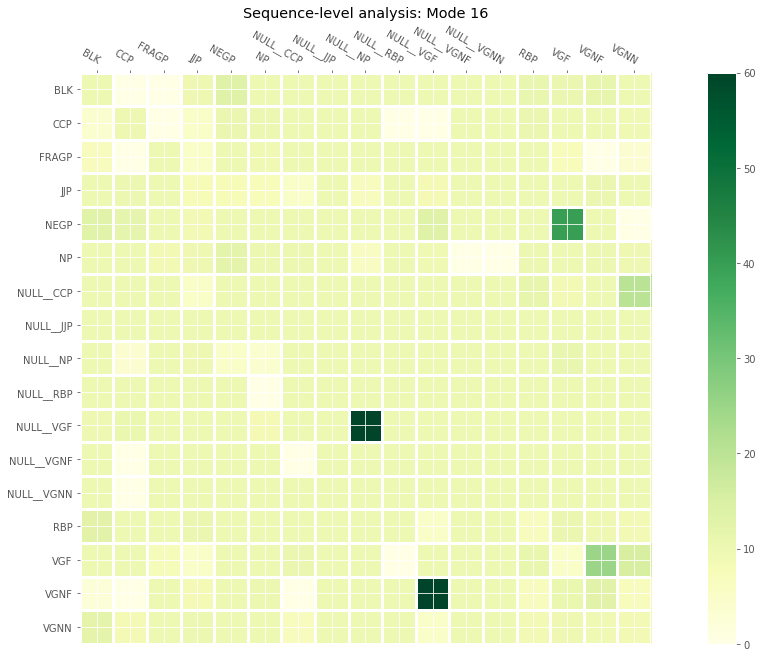

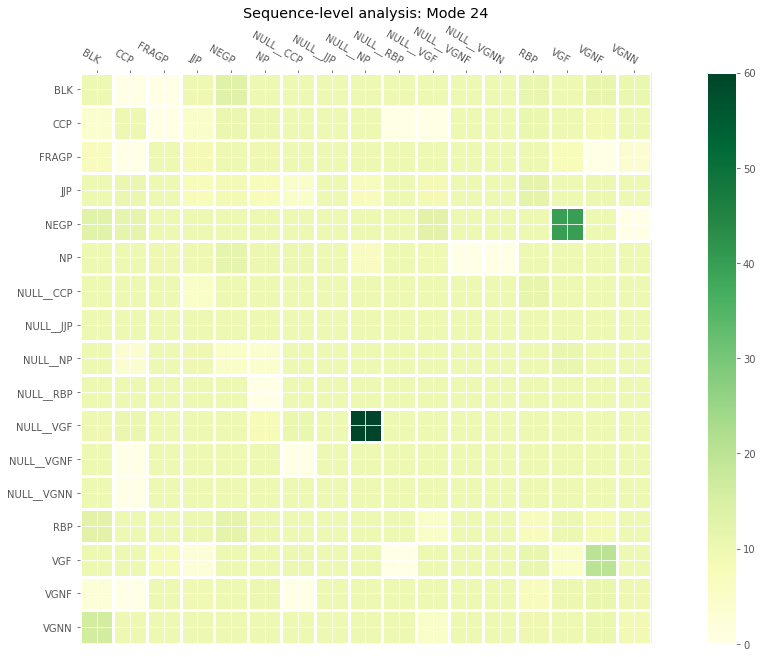

In [330]:
for mode in MODE_LIST:
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 9)
    data, row, col = process_sequence(*modechunk[mode][2])
    npdata = np.array(data) * 10
    heatmap(npdata, row, col, ax=ax, cmap="YlGn")#, vmin=-10, vmax=60)
    fig.tight_layout()
    plt.title(f'Sequence-level analysis: Mode {mode}')
#     plt.suptitle('Predicted / Correct')
    plt.show()

# Process Chunk Boundaries

In [404]:
bnddata = {mode: list(modechunk[mode][3]) for mode in MODE_LIST}
TRANS_BND_MAP = ['Predicted', 'Skipped', 'Extra', 'Diff']

for key, dct in bnddata.items():
    bnddata[key] = dict()
    for i in range(3):
        bnddata[key][TRANS_BND_MAP[i]] = {k: v / dct[3][k] for k, v in dct[i].items() if dct[3][k] > 0}
    bnddata[key][TRANS_BND_MAP[3]] = {k: v - dct[3][k] for k, v in dct[0].items()}

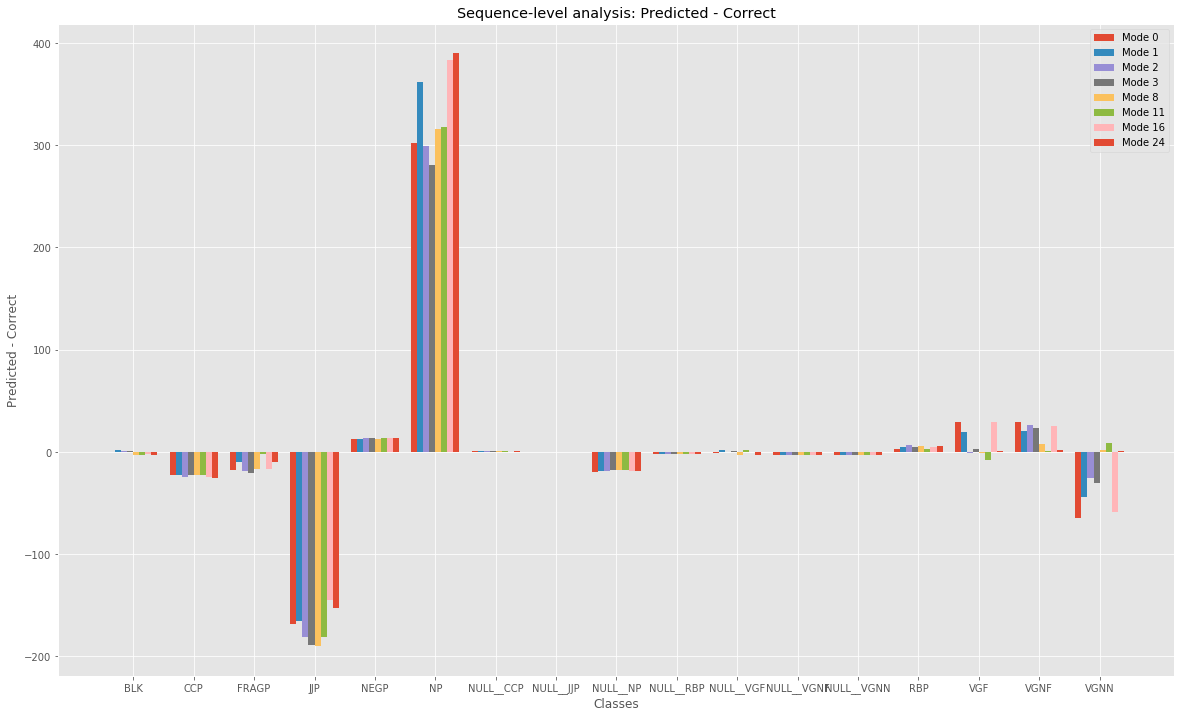

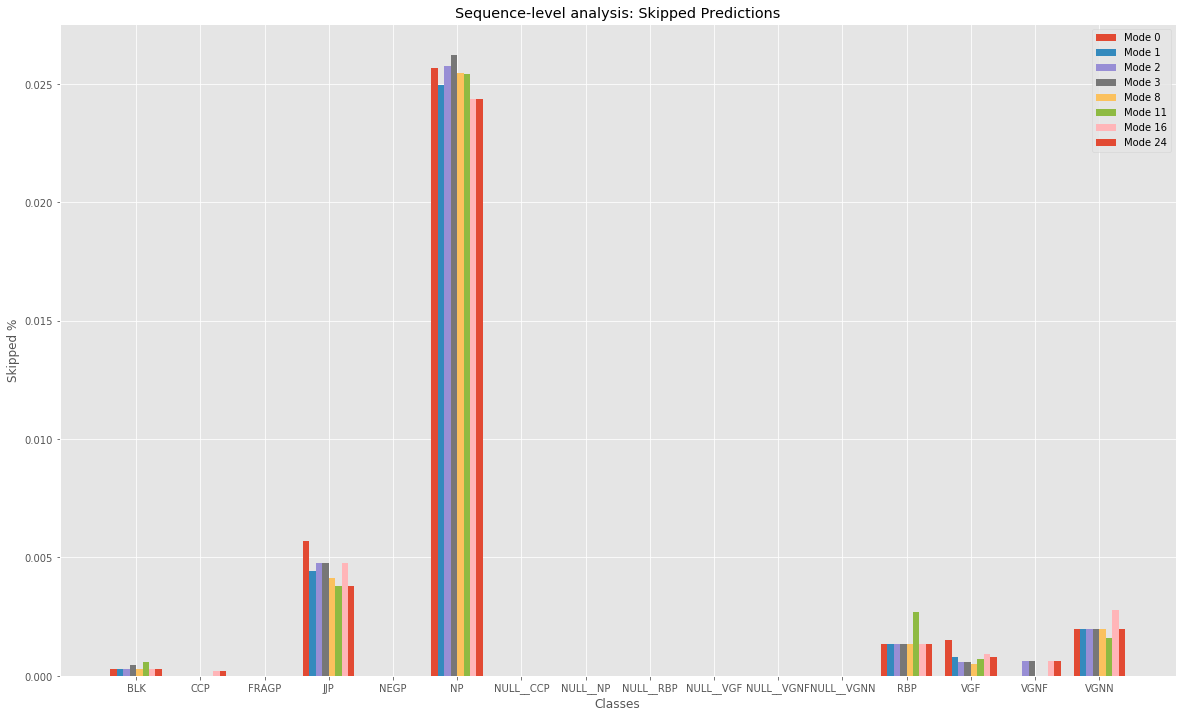

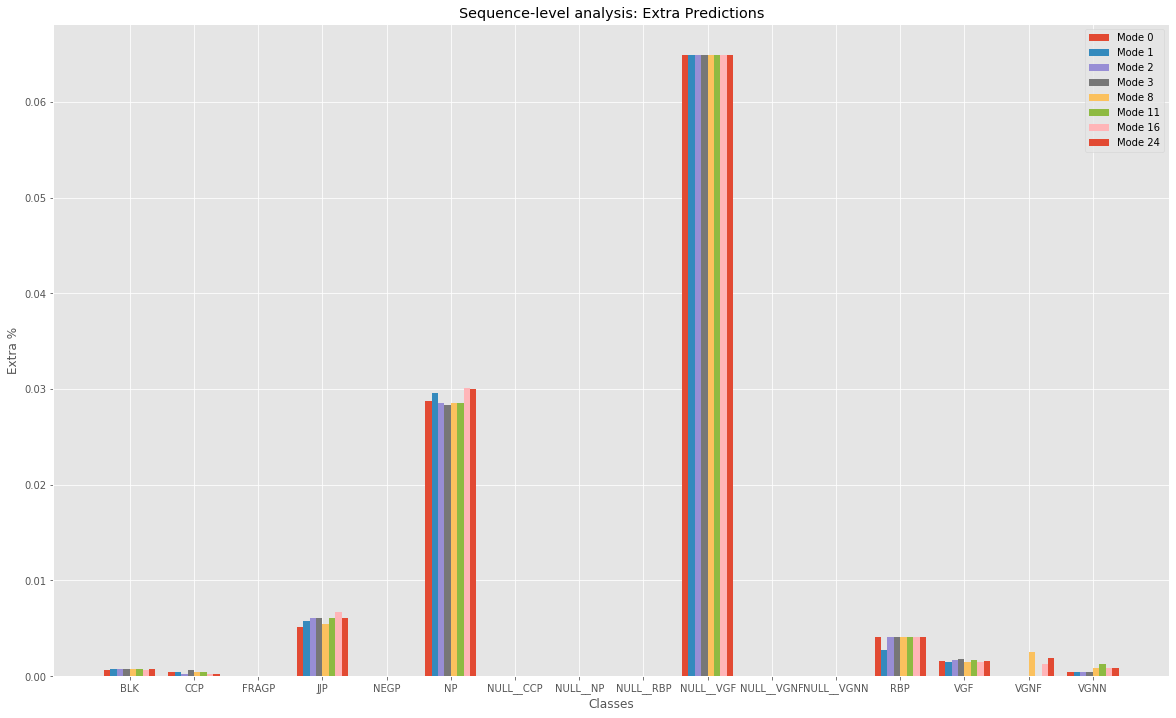

In [406]:
res = {}
for mode, dct in bnddata.items():
    for lbl, dct2 in dct.items():
        for key, val in dct2.items():
            res.setdefault(lbl, dict())
            res[lbl].setdefault(mode, dict())
            res[lbl][mode][key] = val

plot_score(res['Diff'], ylabel='Predicted - Correct', title='Sequence-level analysis: Predicted - Correct')
plot_score(res['Skipped'], ylabel='Skipped %', title='Sequence-level analysis: Skipped Predictions')
plot_score(res['Extra'], ylabel='Extra %', title='Sequence-level analysis: Extra Predictions')

In [402]:
bnddata

{0: {'Predicted': {'BLK': 1.0,
   'CCP': 0.9951973272081854,
   'FRAGP': 0.8548387096774194,
   'JJP': 0.9468017732742242,
   'NEGP': 1.1214953271028036,
   'NP': 1.0073909106482954,
   'NULL__CCP': 1.005,
   'NULL__NP': 0.7872340425531915,
   'NULL__RBP': 0.0,
   'NULL__VGF': 0.9935064935064936,
   'NULL__VGNF': 0.0,
   'NULL__VGNN': 0.0,
   'RBP': 1.0040485829959513,
   'VGF': 1.0029260417717687,
   'VGNF': 1.0183776932826363,
   'VGNN': 0.9741138988450816},
  'Skipped': {'BLK': 0.00030039050765995795,
   'CCP': 0.0,
   'FRAGP': 0.0,
   'JJP': 0.005699810006333122,
   'NEGP': 0.0,
   'NP': 0.025672401556496416,
   'NULL__CCP': 0.0,
   'NULL__NP': 0.0,
   'NULL__RBP': 0.0,
   'NULL__VGF': 0.0,
   'NULL__VGNF': 0.0,
   'NULL__VGNN': 0.0,
   'RBP': 0.001349527665317139,
   'VGF': 0.0015134698819493492,
   'VGNF': 0.0,
   'VGNN': 0.001991238550378335},
  'Extra': {'BLK': 0.0006007810153199159,
   'CCP': 0.00041762372102735435,
   'FRAGP': 0.0,
   'JJP': 0.00506649778340722,
   'NEGP': 0.